## Positive and Negative Sentiments in Job Candidate Emails
> Using the library job-offer-classifier

In [0]:
pip install job-offer-classifier --upgrade > /dev/null

In [114]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# default 

In [0]:
from os import path,listdir
from shutil import rmtree
import pandas as pd
import numpy as np
import job_offer_classifier
from job_offer_classifier.pipeline_classifier import Pipeline
from job_offer_classifier.validations import KFoldPipe
from job_offer_classifier.pipeline_classifier import plot_confusion_matrix

In [117]:
job_offer_classifier.__version__

'0.0.5'

In [0]:
# Shutdown TF info logging
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Data Processing

In [0]:
intekglobal_data = 'https://raw.githubusercontent.com/kikejimenez/ikg_employee_emails/master/data/interim/intekglobal_employee/emails.csv'
sibatel_web_data = 'https://raw.githubusercontent.com/kikejimenez/ikg_employee_emails/master/data/raw/sibatel_and_webpage.csv'
processed_data_file = './sibatel_web_intekglobal_emails/emails.csv'
models_dir = './sibatel_web_intekglobal_emails/estimator/'

In [120]:
path.isdir('sibatel_web_intekglobal_emails')

True

Cibatel+webpage

In [0]:
df = pd.read_csv(sibatel_web_data)
nb_cases = min([min(df.sentiment.value_counts().values),50])
df_pos = df[df.sentiment == 1].sample(nb_cases)
df_neg = df[df.sentiment == 0].sample(nb_cases)

df_sibatel_web = pd.concat([df_pos,df_neg]).sample(frac = 1)

Intekglobal

In [0]:
df = pd.read_csv(intekglobal_data)
df = df[(df.sentiment == 'positive') | (df.sentiment == 'negative')]
df.sentiment = df.sentiment.apply(lambda s: int(s == 'positive'))
df_intekglobal = df
del df

All

In [0]:
df = pd.concat([df_sibatel_web,df_intekglobal.drop('mocker',axis=1)]).sample(frac=1)
df.to_csv(processed_data_file)

In [124]:
df.sentiment.value_counts()

1    94
0    80
Name: sentiment, dtype: int64

## Train the Model

In [0]:
kfp = KFoldPipe(n_splits = 4,src_file=processed_data_file)
kfp.train_steps = 1000

In [0]:
kfp.k_fold_validation()

In [127]:
kfp.best_seed

518738169

In [0]:
kfp.random_state = kfp.best_seed
kfp.pipeline()

In [0]:
rmtree(models_dir,ignore_errors=True)
kfp.export_estimator(models_dir)

## Predictions

In [0]:
kfp = KFoldPipe(n_splits =1,src_file=processed_data_file,estimator_dir=models_dir)
kfp.load_estimator()
kfp.input_fns()

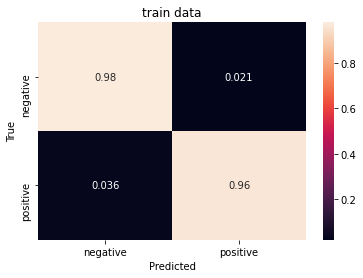

In [131]:
kfp.plot_confusion_matrix('train')

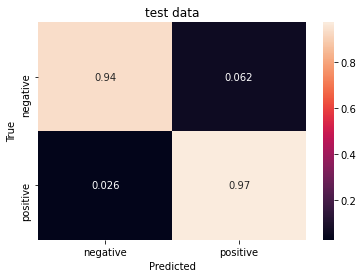

In [132]:
kfp.plot_confusion_matrix('test')

In [136]:
kfp.evaluate()
kfp.evaluation['train']

{'accuracy': 0.97115386,
 'accuracy_baseline': 0.53846157,
 'auc': 0.9940476,
 'auc_precision_recall': 0.995502,
 'average_loss': 0.12028722,
 'f1_score': 0.972972990156294,
 'global_step': 5000,
 'label/mean': 0.53846157,
 'loss': 0.12028722,
 'precision': 0.9818182,
 'prediction/mean': 0.5277839,
 'recall': 0.96428573}

In [137]:
kfp.evaluation['test']

{'accuracy': 0.95714283,
 'accuracy_baseline': 0.54285717,
 'auc': 0.99835527,
 'auc_precision_recall': 0.9986675,
 'average_loss': 0.1066091,
 'f1_score': 0.9610389534388409,
 'global_step': 5000,
 'label/mean': 0.54285717,
 'loss': 0.1066091,
 'precision': 0.94871795,
 'prediction/mean': 0.56569976,
 'recall': 0.9736842}

In [133]:
df_ex = kfp.dfs['test'].sample(5)
df_ex['prediction'] = kfp.predict(df_ex)

for k, r in df_ex.iterrows():
    print(k, sep='\n')
    print(
        r.payload.strip(),
        f'Expected: {r.sentiment}',
        f'Predicted: {r.prediction}',
        sep='\n'
    )

66
thank you again for oﬀering me the opportunity to
work at Jones-Lopez.
as i told you over the phone i regret that i must
decline the job oﬀer.
after considerable thought i
have determined that the position is not the best fit
for me at this time.
i enjoyed meeting you and learning about your
company and i wish you every success in the
future.
Expected: 0
Predicted: 0
22
Hello good afternoon


My name is José Antonio Martínez,
I'm 29 years old, I'm single,
I live in Montemorelos NL, and I would like
participate for the job position available, 
I am available, for learning and traveling.
I am here for any other information you need.
My cell number is 4432178324
I attach my resume.

I would like to work in the United States
I'd like to meet that country

I do not speak English but I can learn over time.
I just want to work. 😔
Expected: 0
Predicted: 1
126
Dear recruiter

thank you for getting in touch with me. I am interested in this job position. But  I haven't finished my bachelor's p